# Augmentation Visualizer

This notebook shows 5 sample plate-crop images for each augmentation preset: `none`, `light`, `medium`, `heavy`.

Run the cells in order. Ensure the repository's virtual environment is active and the current working directory is the `plate_recognizer` folder.

In [15]:
# Cell 1: Load CSV and pick 5 sample rows
from pathlib import Path
import random
import pandas as pd

CSV_PATH = Path('../data/8000/8000.csv')
DATA_ROOT = Path('../data/8000')
assert CSV_PATH.exists(), f'CSV not found: {CSV_PATH}'

df = pd.read_csv(CSV_PATH)
df = df[df['is_validate'] == True].copy()
df = df[df['image_name_gray'].notnull() | df['image_name'].notnull()].copy()

sample_seed = 42
random.seed(sample_seed)
if len(df) >= 5:
    samples = df.sample(n=5, random_state=sample_seed)
else:
    samples = df.copy()

# Resolve image path helper

def resolve_image_row(row):
    # Try several plausible locations and filename fields used in the CSV
    rel = row.get('image_name_gray') or row.get('image_name') or ''
    if not rel or str(rel).strip() == 'nan':
        return None
    # Normalize and strip any leading path separators so '/210/..' becomes relative
    rel = str(rel).strip()
    rel = rel.lstrip('/\\')
    # Some rows may contain nested folders. Try joining as relative to DATA_ROOT
    candidates = [
        DATA_ROOT / rel,
        DATA_ROOT / '210' / rel,
        DATA_ROOT / Path(rel).name,
    ]
    # Also try with common image extensions if missing
    stem = Path(rel).stem
    for ext in ['', '.jpg', '.jpeg', '.png']:
        candidates.append(DATA_ROOT / f'{stem}{ext}')
        candidates.append(DATA_ROOT / '210' / f'{stem}{ext}')
    for p in candidates:
        try:
            if p.exists():
                return p
        except Exception:
            # Path may be invalid on this machine; skip
            continue
    # Not found -> return first candidate (useful for diagnostics)
    return candidates[0] if candidates else None

image_paths = [resolve_image_row(r) for _, r in samples.iterrows()]
# Print diagnostics: show which samples mapped to existing files
for i, p in enumerate(image_paths):
    exists = p.exists() if (p is not None and hasattr(p, 'exists')) else False
    print(f'sample {i}:', p, 'FOUND' if exists else 'MISSING')


sample 0: ..\data\8000\210\2024-07-05\08\Lane1\2024-07-05_08-33-48-847_TRG-071240_Lane1_882184-THA_24.jpg FOUND
sample 1: ..\data\8000\210\2024-07-05\12\Lane1\2024-07-05_12-03-05-815_TRG-075577_Lane1_NOTREAD-_.jpg FOUND
sample 2: ..\data\8000\210\2024-07-05\06\Lane1\2024-07-05_06-06-02-099_TRG-067707_Lane1_บจ1671-THA_47.jpg FOUND
sample 3: ..\data\8000\210\2024-07-05\08\Lane1\2024-07-05_08-14-55-486_TRG-070777_Lane1_4ขฒ4182-THA_10.jpg FOUND
sample 4: ..\data\8000\210\2024-07-05\11\Lane1\2024-07-05_11-09-39-691_TRG-074681_Lane1_530638-THA_22.jpg FOUND


In [16]:
# Cell 2: Imports and lightweight augmentor helpers
from PIL import Image, ImageFilter, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import random

# Minimal augmentor functions mirroring train.build_augmentor presets

def augment_none(img: Image.Image) -> Image.Image:
    return img

def augment_light(img: Image.Image) -> Image.Image:
    if random.random() < 0.5:
        img = img.rotate(random.uniform(-5, 5), resample=Image.BILINEAR)
    if random.random() < 0.15:
        img = img.filter(ImageFilter.GaussianBlur(radius=1))
    if random.random() < 0.3:
        enhancer = ImageEnhance.Color(img)
        img = enhancer.enhance(random.uniform(0.9, 1.1))
    return img

def augment_medium(img: Image.Image) -> Image.Image:
    if random.random() < 0.7:
        img = img.rotate(random.uniform(-10, 10), resample=Image.BILINEAR)
    if random.random() < 0.25:
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.5)))
    if random.random() < 0.4:
        enhancer = ImageEnhance.Color(img)
        img = enhancer.enhance(random.uniform(0.8, 1.2))
    if random.random() < 0.15:
        arr = np.array(img)
        noise = (np.random.randn(*arr.shape) * 6).clip(-128, 127).astype('int16')
        arr = (arr.astype('int16') + noise).clip(0, 255).astype('uint8')
        img = Image.fromarray(arr)
    return img

def augment_heavy(img: Image.Image) -> Image.Image:
    if random.random() < 0.85:
        img = img.rotate(random.uniform(-15, 15), resample=Image.BILINEAR)
    if random.random() < 0.35:
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(1.0, 2.5)))
    if random.random() < 0.5:
        enhancer = ImageEnhance.Color(img)
        img = enhancer.enhance(random.uniform(0.7, 1.3))
    if random.random() < 0.25:
        arr = np.array(img)
        h, w = arr.shape[:2]
        rw = int(w * random.uniform(0.1, 0.35))
        rh = int(h * random.uniform(0.1, 0.35))
        x = random.randint(0, max(0, w - rw))
        y = random.randint(0, max(0, h - rh))
        arr[y:y+rh, x:x+rw] = 0
        img = Image.fromarray(arr)
    if random.random() < 0.25:
        arr = np.array(img)
        noise = (np.random.randn(*arr.shape) * 10).clip(-128, 127).astype('int16')
        arr = (arr.astype('int16') + noise).clip(0, 255).astype('uint8')
        img = Image.fromarray(arr)
    return img

AUGMENTORS = {
    'none': augment_none,
    'light': augment_light,
    'medium': augment_medium,
    'heavy': augment_heavy,
}


C:\Users\PC\AppData\Local\Temp\ipykernel_20584\1876823540.py:34: UserWarning: Glyph 3610 (\N{THAI CHARACTER BO BAIMAI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_20584\1876823540.py:34: UserWarning: Glyph 3592 (\N{THAI CHARACTER CHO CHAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_20584\1876823540.py:34: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_20584\1876823540.py:34: UserWarning: Glyph 3602 (\N{THAI CHARACTER THO PHUTHAO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3610 (\N{THAI CHARACTER BO BAIMAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabt

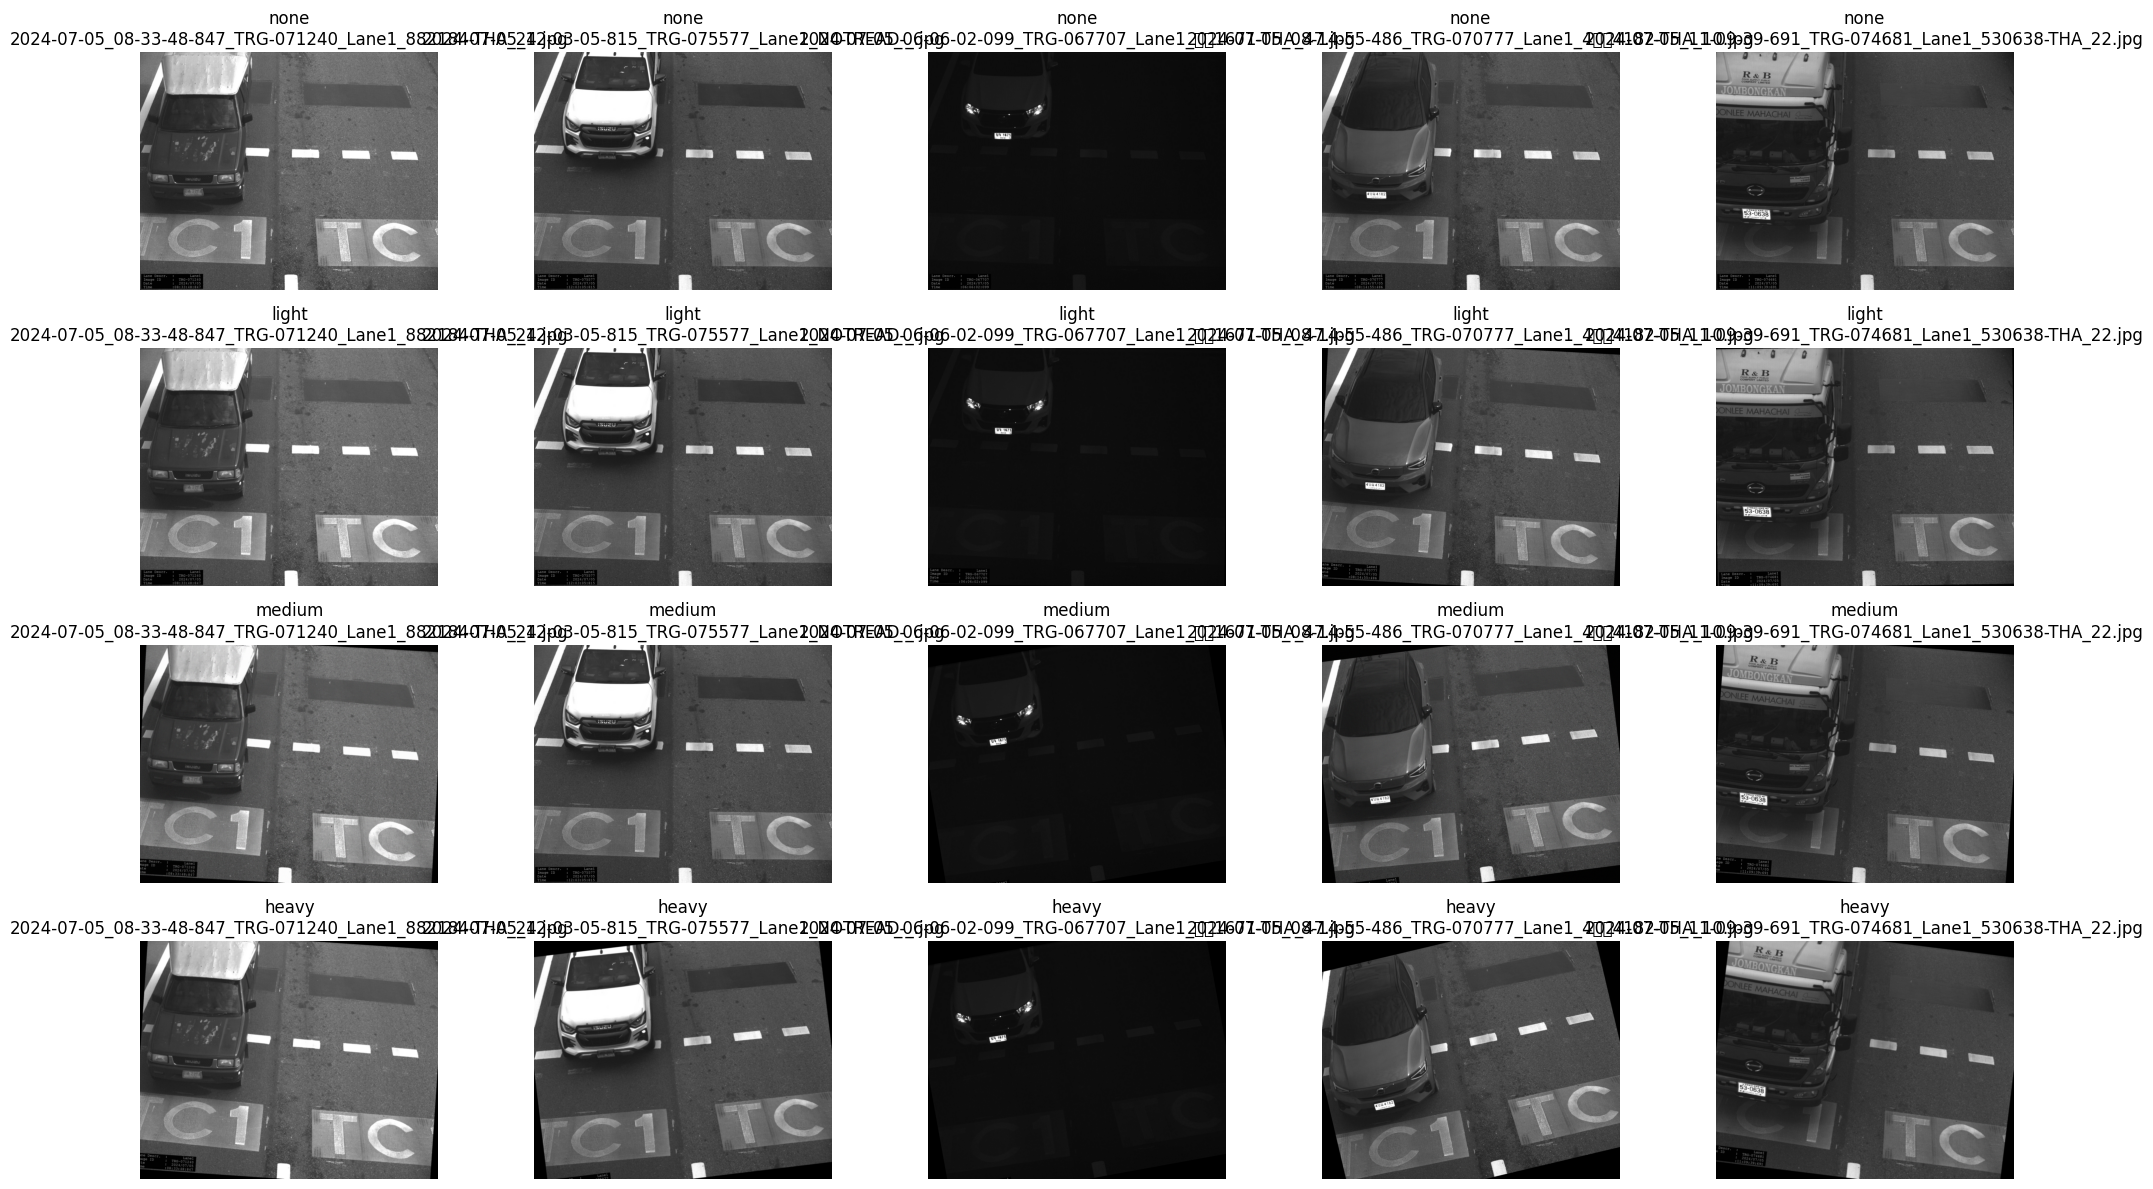

C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Glyph 3610 (\N{THAI CHARACTER BO BAIMAI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Glyph 3592 (\N{THAI CHARACTER CHO CHAN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Glyph 3602 (\N{THAI CHARACTER THO PHUTHAO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)


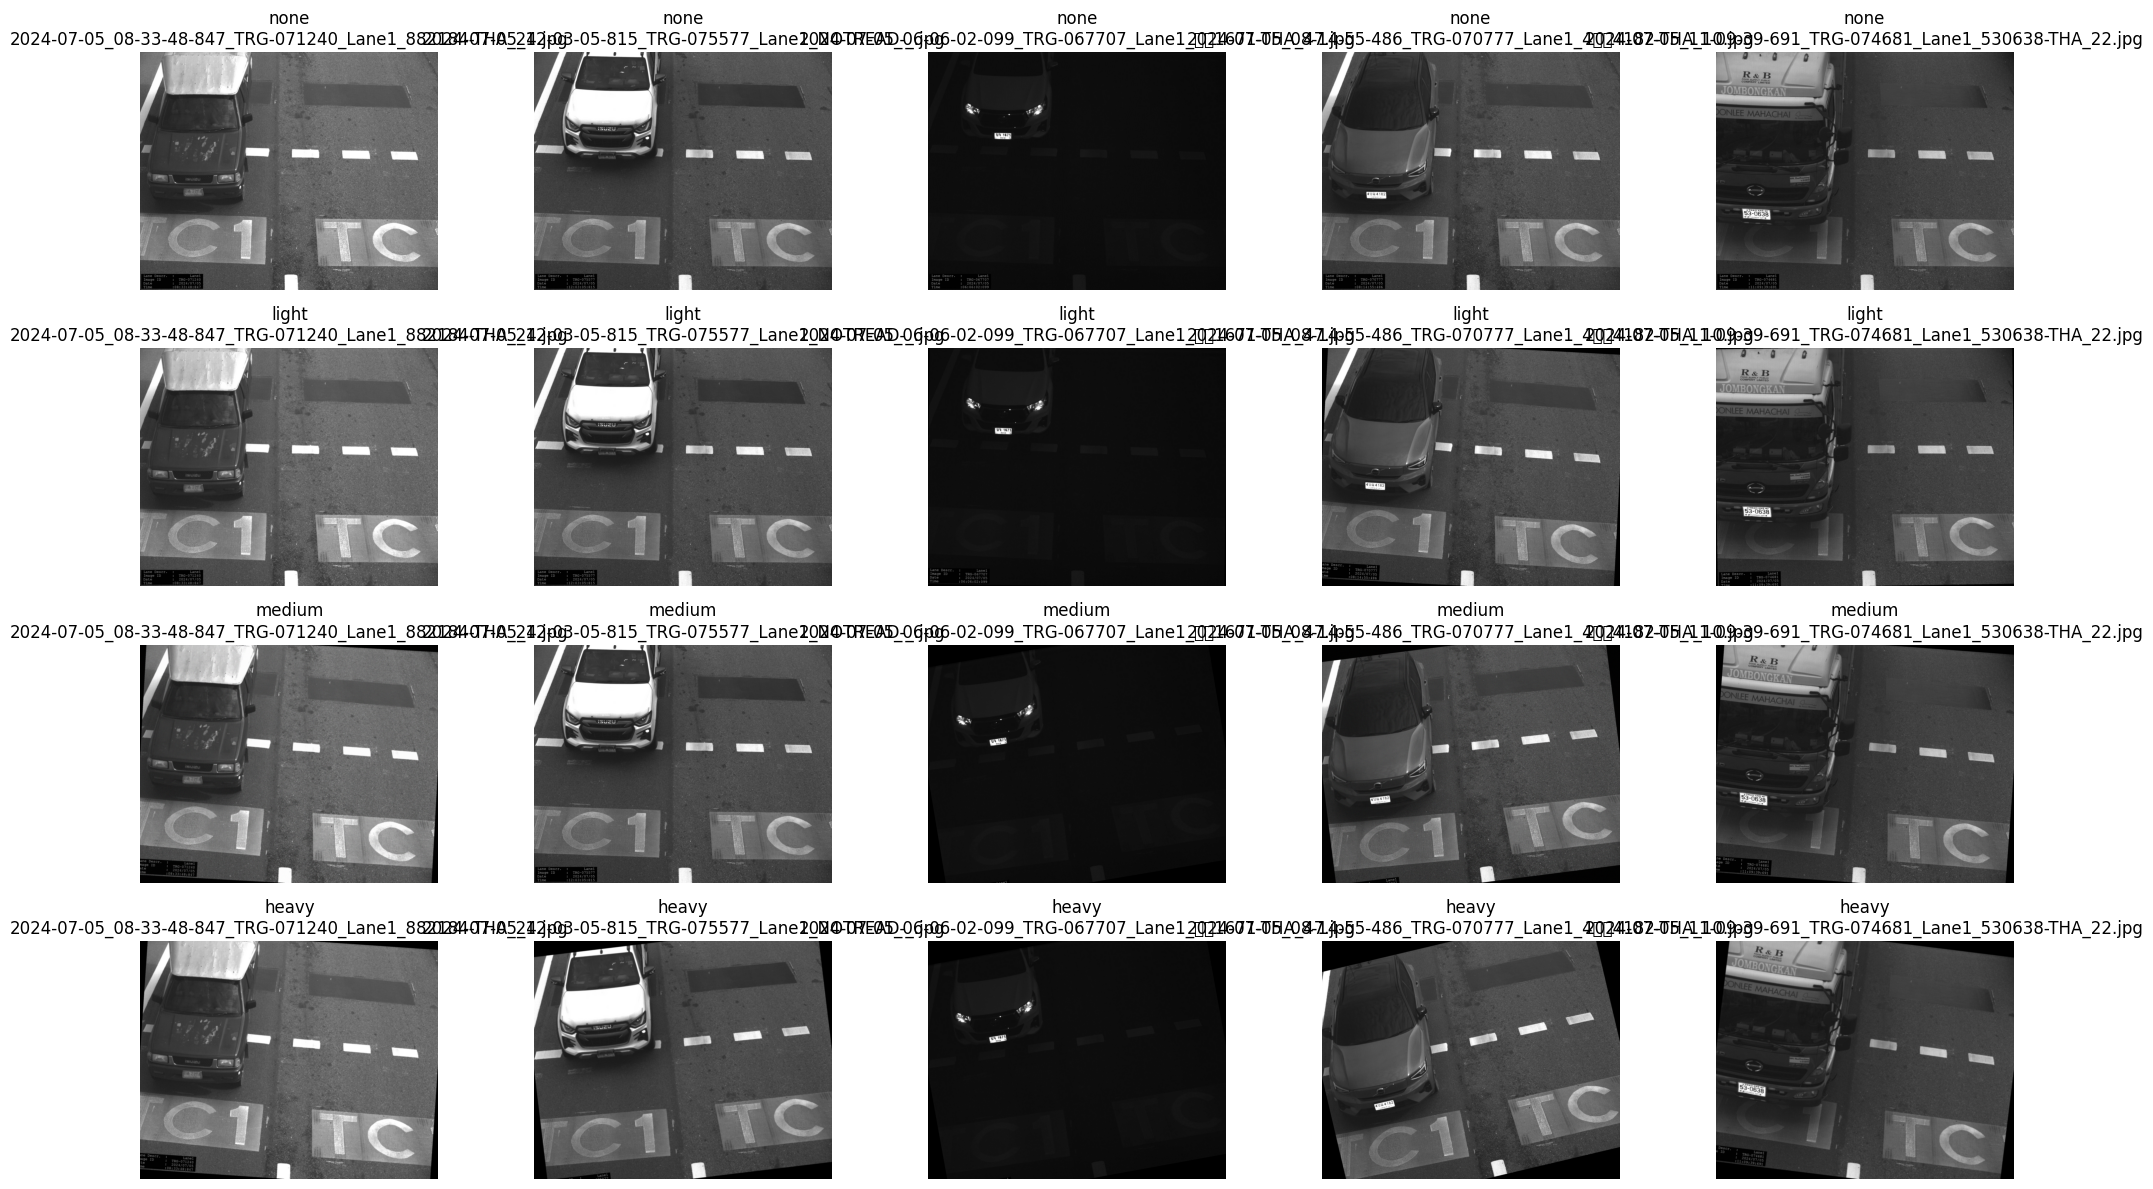

In [17]:
# Cell 3: Display augmented images grid (up to 5 samples x 4 presets)
from IPython.display import display
from PIL import Image

PRESETS = ['none', 'light', 'medium', 'heavy']
max_n = 5  # desired samples per preset
# Filter only existing image paths
valid_image_paths = [p for p in image_paths if p is not None and getattr(p, 'exists', lambda: False)()]
if not valid_image_paths:
    print('No valid image files were found for the selected samples. See the diagnostics printed above from Cell 1 to investigate paths.')
else:
    n = min(max_n, len(valid_image_paths))
    fig_w = 4 * n
    fig_h = 3 * len(PRESETS)
    fig, axes = plt.subplots(len(PRESETS), n, figsize=(fig_w, fig_h))

    for i, preset in enumerate(PRESETS):
        aug_fn = AUGMENTORS[preset]
        for j in range(n):
            ax = axes[i, j] if len(PRESETS) > 1 else axes[j]
            img_path = valid_image_paths[j]
            try:
                img = Image.open(img_path).convert('RGB')
            except Exception as e:
                ax.set_title('error')
                ax.text(0.5, 0.5, str(e), wrap=True, ha='center')
                ax.axis('off')
                continue
            aug_img = aug_fn(img.copy())
            ax.imshow(aug_img)
            ax.set_title(f'{preset}\n{img_path.name}')
            ax.axis('off')

    plt.tight_layout()
    display(fig)
